# Assignment 4

In this assignment, you will be using univariate LSTM models on time series.

* [1. Introduction](#h1)  

* [2. Univariate time series: LSTM](#h2)  

 


In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [1]:
%cd gdrive/My\ Drive/Colab\ Notebooks/hw4

/content/gdrive/My Drive/Colab Notebooks/hw4


## 1. Introduction <a name="h1"></a>

In this homework, we will model temporal trends on sales price of items from a grocery store. There are 50 items from 10 locations. We will first look at univariate temporal trends, which means that only one item from one location is picked. Then we will run a univariate LSTM model to predict the temporal trend.

In [3]:
!pip install --upgrade statsmodels

     |████████████████████████████████| 9.5MB 2.6MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [4]:
import matplotlib.pyplot as plt  
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from scipy.stats import normaltest
from sklearn.metrics import mean_squared_error
import math

color = sns.color_palette()
sns.set_style('darkgrid')

# save me from using display function every time I have multiple outputs in one cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Download data from [GitHub](https://github.com/yuankaihuo/DL_course_hw/tree/master/Homework%202/data) and save them on your drive

In [5]:
# load data
train_data = pd.read_csv("data/train.csv",parse_dates=['date'])

# focus on 1 store and 1 item
train_data = train_data[(train_data['store']==1) & (train_data['item']==1)] # 1460 by 4

train_data['year'] = train_data['date'].dt.year
train_data['month'] = train_data['date'].dt.month
train_data['day'] = train_data['date'].dt.dayofyear
train_data['weekday'] = train_data['date'].dt.weekday

# make training and validation sets 
days = train_data.shape[0]
train_df = train_data.iloc[:(days - 90),:] # 3 years and 9 months
validate_df = train_data.iloc[-90:,:] # last 90 days

print("The training set has " + str(train_df.shape[0]) +" rows, and " + str(train_df.shape[1]) + " columns.")
print("The validation set has " + str(validate_df.shape[0]) +" rows, and " + str(validate_df.shape[1]) + " columns.")

The training set has 1370 rows, and 8 columns.
The validation set has 90 rows, and 8 columns.


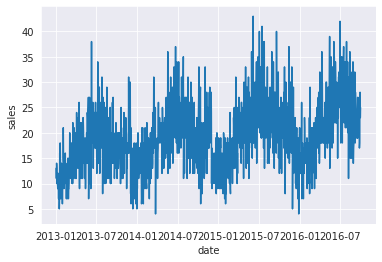

In [6]:
# full temporal trend
sns.lineplot(x="date", y="sales",legend = 'full' , data=train_df)
plt.show()

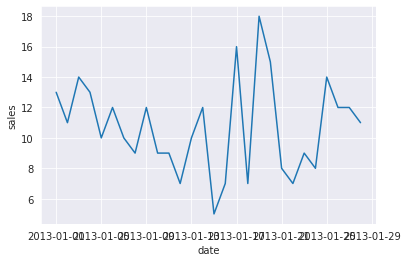

In [7]:
# temporal trend of first 28 days
sns.lineplot(x="date", y="sales",legend = 'full' , data=train_df[:28])
plt.show()

### Seasonality decomposition

<Figure size 432x288 with 0 Axes>

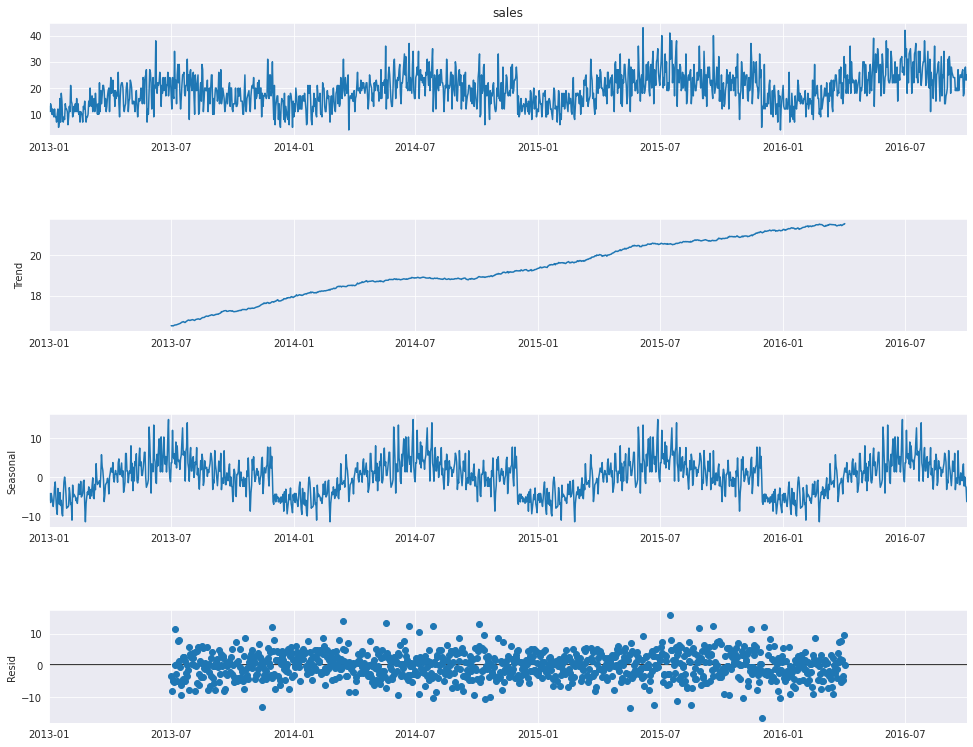

In [8]:
train_df = train_df.set_index('date')
train_df['sales'] = train_df['sales'].astype(float)
validate_df = validate_df.set_index('date')
validate_df['sales'] = validate_df['sales'].astype(float)

result = seasonal_decompose(train_df['sales'], model='additive',period=365)

fig = plt.figure()
fig = result.plot()
fig.set_size_inches(15, 12)
plt.show()


## 2. Univariate time series: LSTM <a name="h2"></a>

Again, we use the item 1 from store 1 as an example to illustrate how LSTM works with one dimensional input.

In [2]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size


The training data set has 3 years and 9 months data, and the validation data set has 3 months data.  

In [3]:
# reading the input data
train_df = pd.read_csv('data/train.csv',parse_dates=['date'])
train_df = train_df[(train_df['store'] == 1) & (train_df['item'] == 1)]

all_train_data = train_df['sales'].values.astype(float)

train_data = all_train_data[:-90] # 3 years and 9 months
test_data = all_train_data[-90:] # last 90 days


First, let's scale the data

In [4]:
# scale data
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
test_data_normalized = scaler.fit_transform(test_data .reshape(-1, 1))
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)

Set the training window to be 7 days. You can tune this parameter for better performance.  

In [5]:
# moving window
train_window = 7

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
test_inout_seq = create_inout_sequences(test_data_normalized, train_window)


class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

model = LSTM()

def model_train(epochs = 30):
    
    test_loss_min = 100
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for i in range(1,epochs+1):
        for seq, labels in train_inout_seq:
            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))

            y_pred = model(seq)

            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()

        # validation
        with torch.no_grad():
            for seq, labels in test_inout_seq:
                y_test_pred = model(seq)
                test_loss = loss_function(y_test_pred.float(), labels)
        
        if test_loss < test_loss_min:
            # Save model
            torch.save(model.state_dict(), 'best_model.pt')
            test_loss_min = test_loss

        if i%10 == 0:
            print(f'Epoch {i} train loss: {single_loss.item():.4f} test loss: {test_loss.item():.4f}')

Train the model 

In [6]:
model_train(epochs=200)

Epoch 10 train loss: 0.0006 test loss: 0.1178
Epoch 20 train loss: 0.0008 test loss: 0.1885
Epoch 30 train loss: 0.0767 test loss: 0.2382
Epoch 40 train loss: 0.0676 test loss: 0.2201
Epoch 50 train loss: 0.0266 test loss: 0.2047
Epoch 60 train loss: 0.0140 test loss: 0.2481
Epoch 70 train loss: 0.0028 test loss: 0.2262
Epoch 80 train loss: 0.0040 test loss: 0.1760
Epoch 90 train loss: 0.0422 test loss: 0.1106
Epoch 100 train loss: 0.0010 test loss: 0.0707
Epoch 110 train loss: 0.0023 test loss: 0.1261
Epoch 120 train loss: 0.0045 test loss: 0.0806
Epoch 130 train loss: 0.0001 test loss: 0.0535
Epoch 140 train loss: 0.0004 test loss: 0.0834
Epoch 150 train loss: 0.0099 test loss: 0.0380
Epoch 160 train loss: 0.0003 test loss: 0.1634
Epoch 170 train loss: 0.0199 test loss: 0.1833
Epoch 180 train loss: 0.0017 test loss: 0.0220
Epoch 190 train loss: 0.0002 test loss: 0.0008
Epoch 200 train loss: 0.0025 test loss: 0.0167


Prediction in the validation set (next 90 days)

In [7]:
model.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

In [8]:

fut_pred = 90

test_inputs = train_data_normalized[-train_window:].tolist()
# print(test_inputs)

model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))


Plot prediction calibration

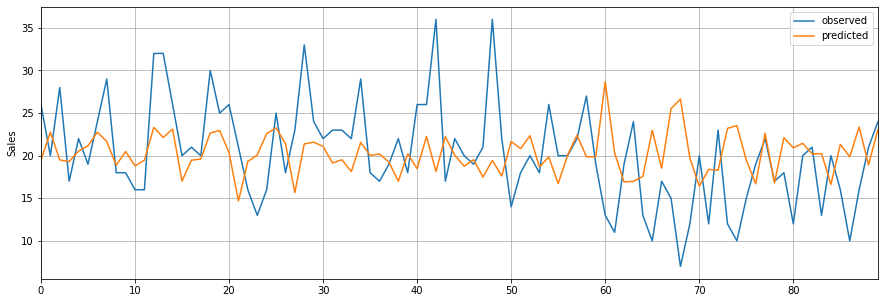

In [9]:
# plot calibration
plt.ylabel('Sales')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(test_data,label="observed")
plt.plot(actual_predictions,label="predicted")
plt.legend()
plt.show()


Calculate prediction RMSE

In [10]:
# rmse
math.sqrt(mean_squared_error(test_data,actual_predictions))

6.488064644712812